In [1]:
from layout_gnn.model.lightning_module import LayoutGraphModelCNNNeuralRasterizer
from layout_gnn.dataset.dataset import RICOSemanticAnnotationsDataset
from layout_gnn.dataset import transformations
from torchvision import transforms

import pandas as pd
import numpy as np
from pathlib import Path
import multiprocessing
import gzip
import json
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, GCN
from torch.utils.data import DataLoader
from layout_gnn.utils import pyg_data_collate
from layout_gnn.similarity_metrics import compute_iou
from tqdm.autonotebook import tqdm

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
ROOT_PATH = Path.cwd()
DATA_PATH = ROOT_PATH / '../data'

In [3]:
design_topics = pd.read_csv(DATA_PATH / 'design_topics.csv')
design_files = design_topics['screen_id'].tolist()
with open(DATA_PATH / 'train_split.json', 'r') as fp:
    splits = json.load(fp)
    
test_files = [f[:-4] for f in splits['train_uis']]

dataset = RICOSemanticAnnotationsDataset(
    transform=transforms.Compose([
        transformations.process_data,
        transformations.normalize_bboxes,
        transformations.add_networkx,
    ]),
    only_data=True
)
label_mappings = {k: i for i, k in enumerate(dataset.label_color_map)}

# Evaluate UI/GED Pairs correlation

In [4]:
with open(DATA_PATH / 'pairs.json', 'r') as fp:
    train_pairs = json.load(fp)

In [5]:
iou_anchors = [d['anchor'] for d in train_pairs if 'pos_iou' in d and 'neg_iou' in d]
ged_anchors = [d['anchor'] for d in train_pairs if 'pos_ged' in d and 'neg_ged' in d]
print("{}% of the anchors are the same".format(100 * len(set(iou_anchors) & set(ged_anchors)) / len(set(iou_anchors) | set(ged_anchors)))) 

99.84340386525093% of the anchors are the same


In [6]:
anchors = set(iou_anchors) & set(ged_anchors)
pairs_dict = {d['anchor']: d for d in train_pairs}

In [7]:
neg_iou = [pairs_dict[anchor]['neg_iou']['pair'] for anchor in anchors]
neg_ged = [pairs_dict[anchor]['neg_ged']['pair'] for anchor in anchors]
print("{}% of the negatives are the same".format(100 * len(set(neg_iou) & set(neg_ged)) / len(set(neg_iou) | set(neg_ged)))) 


51.00262368815592% of the negatives are the same


In [8]:
pos_iou = [pairs_dict[anchor]['pos_iou']['pair'] for anchor in anchors]
pos_ged = [pairs_dict[anchor]['pos_ged']['pair'] for anchor in anchors]
print("{}% of the positive are the same".format(100 * len(set(pos_iou) & set(pos_ged)) / len(set(pos_iou) | set(pos_ged)))) 

70.42494748747778% of the positive are the same


# Document Query Analysis

In [13]:
query_results = [
    {   'query': '71732',
        'iou': ['40712', '71739', '60719', '45210', '69439'],
        'gccn_cnn':  ['34548', '1298', '19600', '59774', '59314'],
        'layoutgmn': ['34548', '19684', '32874', '67220', '7497']
    },
    {   
        'query': '17951',
        'iou': ['17938', '17942', '17927', '17950', '17935'],
        'gccn_cnn':  ['17938', '57062', '53241', '29059', '36258'],
        'layoutgmn': ['17938', '17942', '17935', '17948', '17950']
    },
    {   
        'query': '1626',
        'iou': ['1629', '35681', '62100', '9121', '4321'],
        'gccn_cnn':  ['35681', '1629', '36086', '5137', '58753'],
        'layoutgmn': ['35681', '1626', '28222', '29913', '29911']
    },
    {   
        'query': '9890',
        'iou': ['68928', '68918', '1969', '711', '68915'],
        'gccn_cnn':  ['64095', '46025', '46030', '27594', '3560'],
        'layoutgmn': ['63074', '12905', '44429', '49151', '54066']
    },
    {   
        'query': '1827',
        'iou': ['1856', '18243', '18986', '18987', '33070'],
        'gccn_cnn':  ['1856', '23722', '66203', '26483', '18054'],
        'layoutgmn': ['1856', '28210', '2740', '46495', '3497']
    },
    {   
        'query': '31334',
        'iou': ['58253', '5041', '13878', '68345', '33205'],
        'gccn_cnn':  ['1184', '14999', '53128', '63862', '62851'],
        'layoutgmn': ['5041', '10766', '55199', '13878', '33205']
    },
]

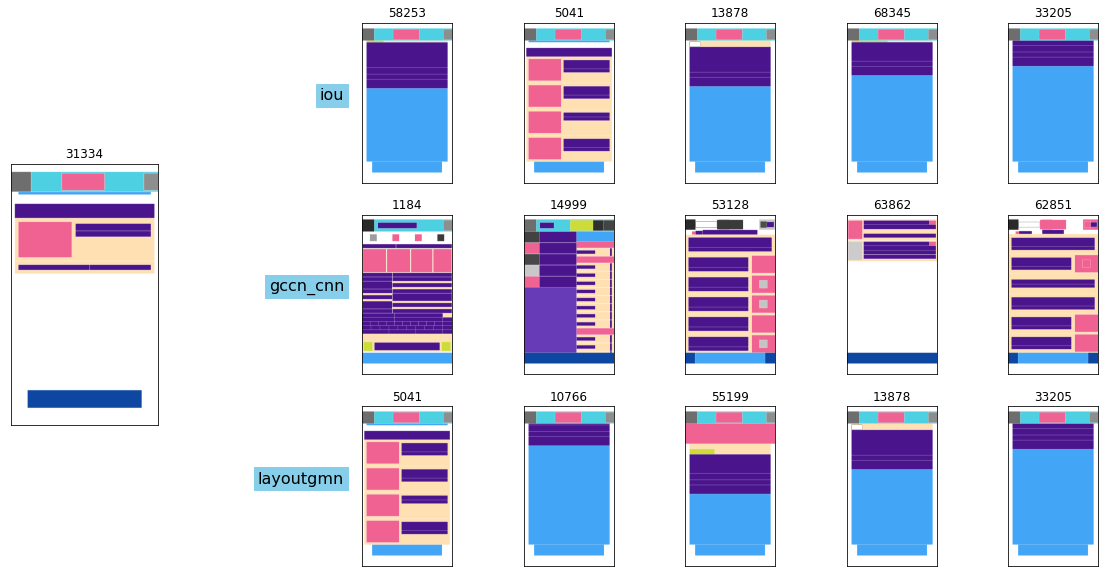

In [14]:
def plot_query(datapoint): 
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(len(datapoint) - 1, 7, wspace=0.1, hspace=0.2, figure=fig)
    ax = plt.subplot(grid[:, 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    img_name = datapoint['query']
    im_path = f'/media/disk/workspace/Layout-GNN/data/semantic_annotations/{img_name}.png'
    img = mpimg.imread(im_path)
    ax.imshow(img)
    ax.set_title(img_name)
    
    neighbors = {k: v for k, v in datapoint.items() if k != 'query'}
    for row_idx, (k, v) in enumerate(neighbors.items()):
        for col_idx, img_name in enumerate(v):
            ax = plt.subplot(grid[row_idx, col_idx+2])
            im_path = f'/media/disk/workspace/Layout-GNN/data/semantic_annotations/{img_name}.png'
            img = mpimg.imread(im_path)
            ax.set_title(img_name)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)
            if col_idx == 0:
                ax.set_ylabel(
                    k,
                    fontsize=16,
                    backgroundcolor='skyblue',
                    color='black', 
                    rotation='horizontal', 
                    horizontalalignment='right'
                )
                ax.yaxis.set_label_coords(-0.2,0.5)
        
        
        
plot_query(query_results[-1])

## Model Preds

In [15]:
BATCH_SIZE = 16
IMAGE_SIZE = 64
NUM_WORKERS = 1
# Encoder (GNN) arguments
LABEL_EMBEDDING_DIM = 64
BBOX_EMBEDDING_LAYER_DIMS = [32, 64]
GNN_HIDDEN_CHANNELS = 256
GNN_OUT_CHANNELS = None
GNN_NUM_LAYERS = 4
GNN_MODEL_CLS = GCN
USE_EDGE_ATTR = False
EDGE_LABEL_EMBEDDING_DIM = 16
READOUT = lambda x, inputs: global_mean_pool(x, batch=inputs.batch)
# Decoder (CNN) arguments
CNN_HIDDEN_DIM = 16
TRIPLET_LOSS_DISTANCE_FUNCTION = lambda x1, x2: 1 - F.cosine_similarity(x1, x2)
# Loss/optimizer parameters
TRIPLET_LOSS_MARGIN = .5
RECONSTRUCTION_LOSS_WEIGHT = 1
LR = 0.001

In [16]:
args = {'num_labels': len(label_mappings) + 1,
        'label_embedding_dim': LABEL_EMBEDDING_DIM,
        'bbox_embedding_layer_dims': BBOX_EMBEDDING_LAYER_DIMS,
        'gnn_hidden_channels': GNN_HIDDEN_CHANNELS,
        'gnn_num_layers': GNN_NUM_LAYERS,
        'gnn_out_channels': GNN_OUT_CHANNELS,
        'gnn_model_cls': GNN_MODEL_CLS,
        'use_edge_attr': USE_EDGE_ATTR,
        'num_edge_labels': 2,
        'edge_label_embedding_dim': EDGE_LABEL_EMBEDDING_DIM,
        'readout': READOUT,
        'cnn_output_dim': 3,
        'cnn_hidden_dim': CNN_HIDDEN_DIM,
        'cnn_output_size': IMAGE_SIZE,
        'triplet_loss_distance_function': TRIPLET_LOSS_DISTANCE_FUNCTION,
        'triplet_loss_margin': TRIPLET_LOSS_MARGIN,
        'reconstruction_loss_weight': RECONSTRUCTION_LOSS_WEIGHT,
        'lr':LR}
model = LayoutGraphModelCNNNeuralRasterizer.load_from_checkpoint(DATA_PATH / 'model' / 'epoch=9-step=16360.ckpt', **args)

In [17]:
dataset.transform = transforms.Compose([
    transformations.process_data,
    transformations.normalize_bboxes,
    transformations.add_networkx,
    transformations.ConvertLabelsToIndexes(
        node_label_mappings=label_mappings,
        edge_label_mappings={"parent_of": 0, "child_of": 1} if USE_EDGE_ATTR else None,
    ),
    transformations.convert_graph_to_pyg,
])

In [18]:
embedings = []
with torch.no_grad():
    for data in tqdm(dataset):
        embedings += [model.encoder(pyg_data_collate([data])).detach().numpy()]

  0%|          | 0/65536 [00:00<?, ?it/s]

In [20]:
layout_embeddings = np.concatenate(embedings, axis=0)

In [21]:
for data in query_results:
    filename = data['query']
    file_idx = dataset.files.index(Path(f'/media/disk/workspace/Layout-GNN/data/semantic_annotations/{filename}.json'))
    dist_matrix = cdist(layout_embeddings[[file_idx], :], layout_embeddings, metric='cosine')
    neighbor_files = [dataset.files[idx].stem for idx in np.argsort(dist_matrix[0]) if idx != file_idx][:5]
    data['ours'] = neighbor_files

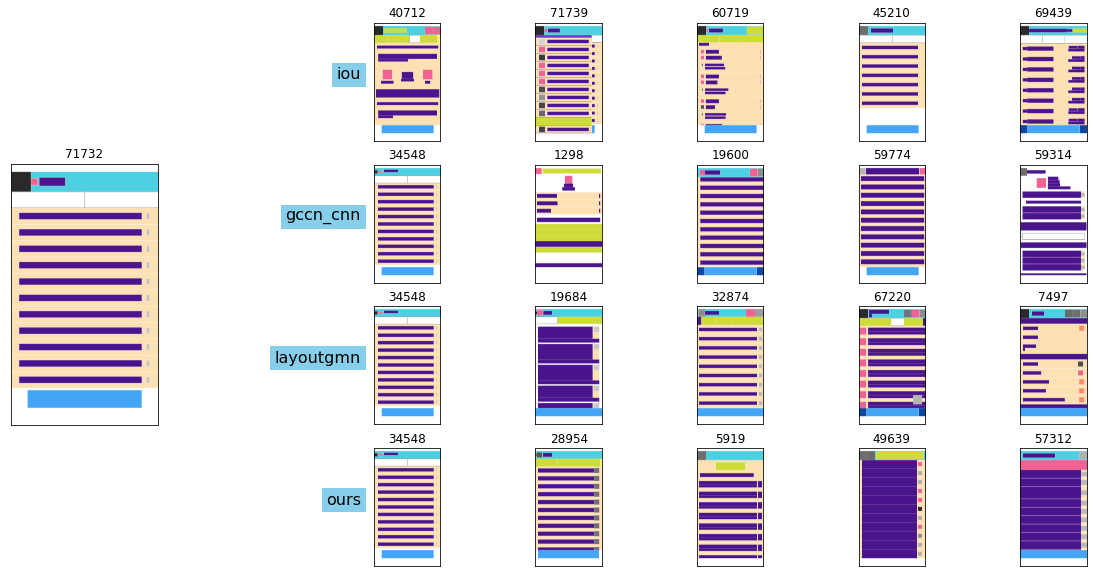

In [22]:
plot_query(query_results[0])

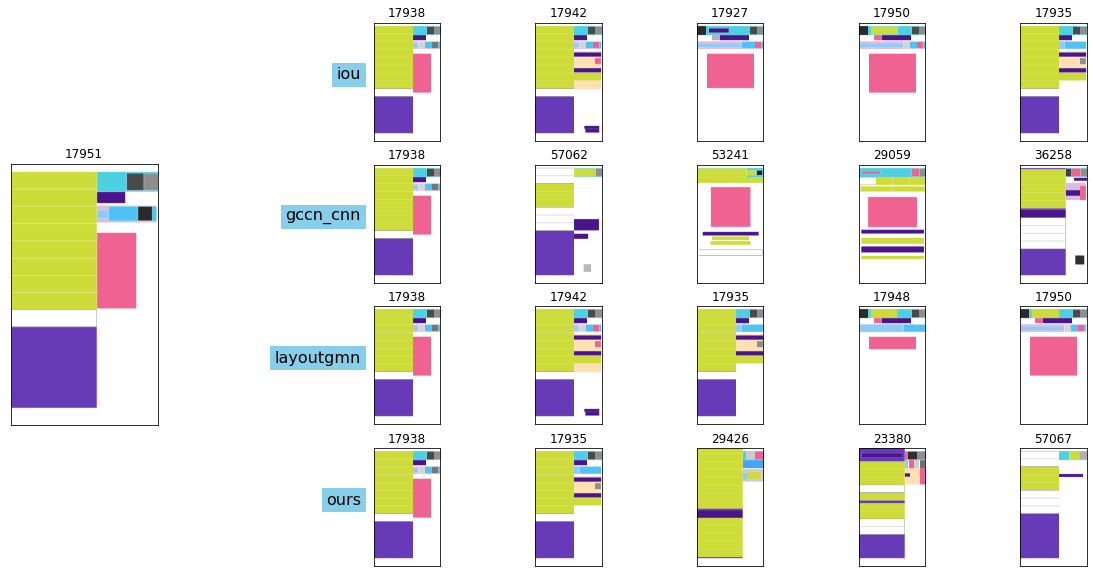

In [23]:
plot_query(query_results[1])

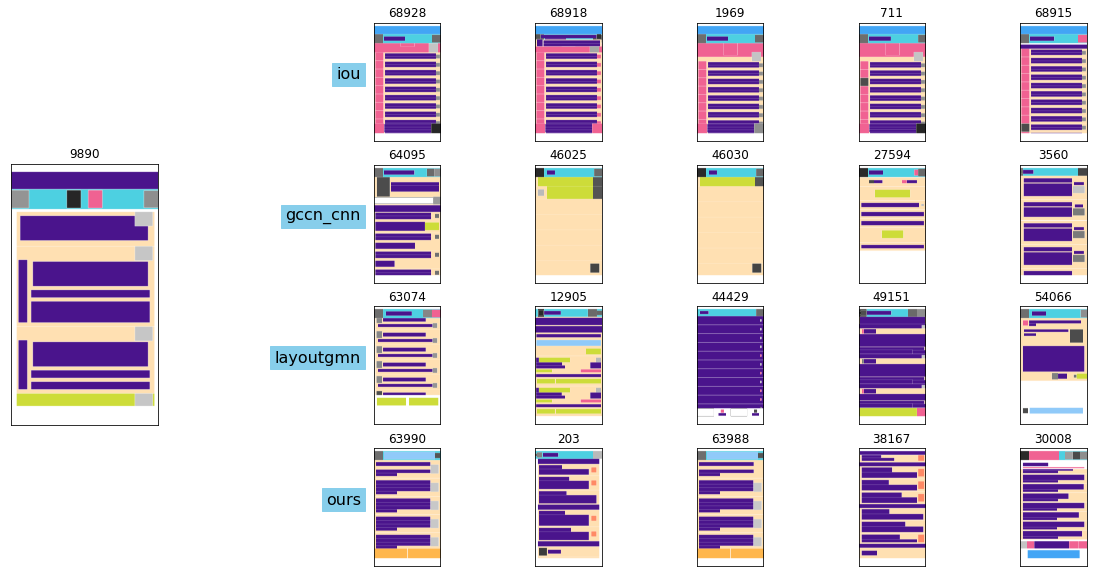

In [24]:
plot_query(query_results[3])

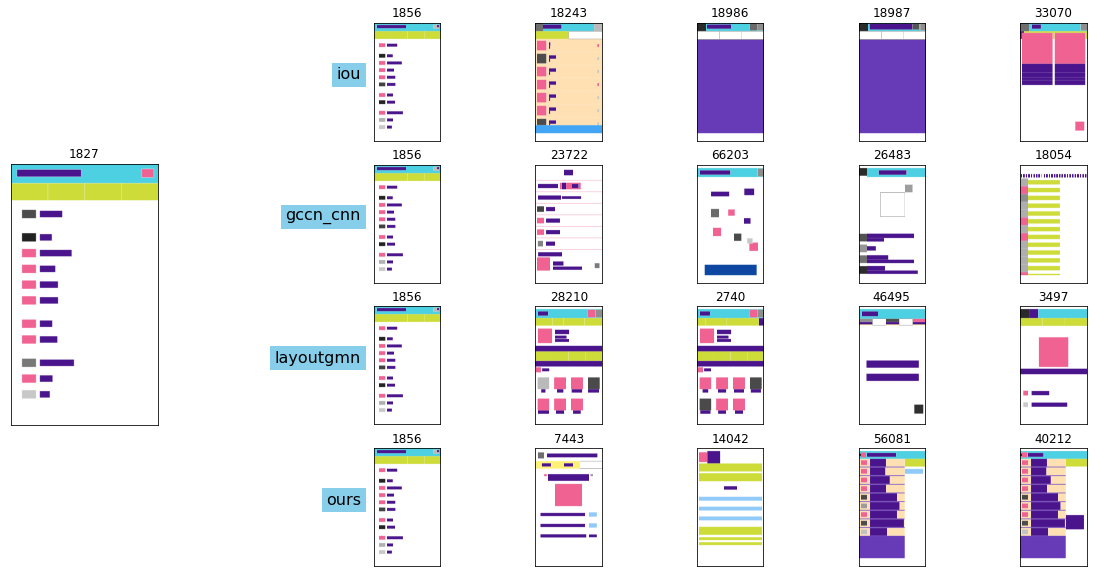

In [25]:
plot_query(query_results[4])


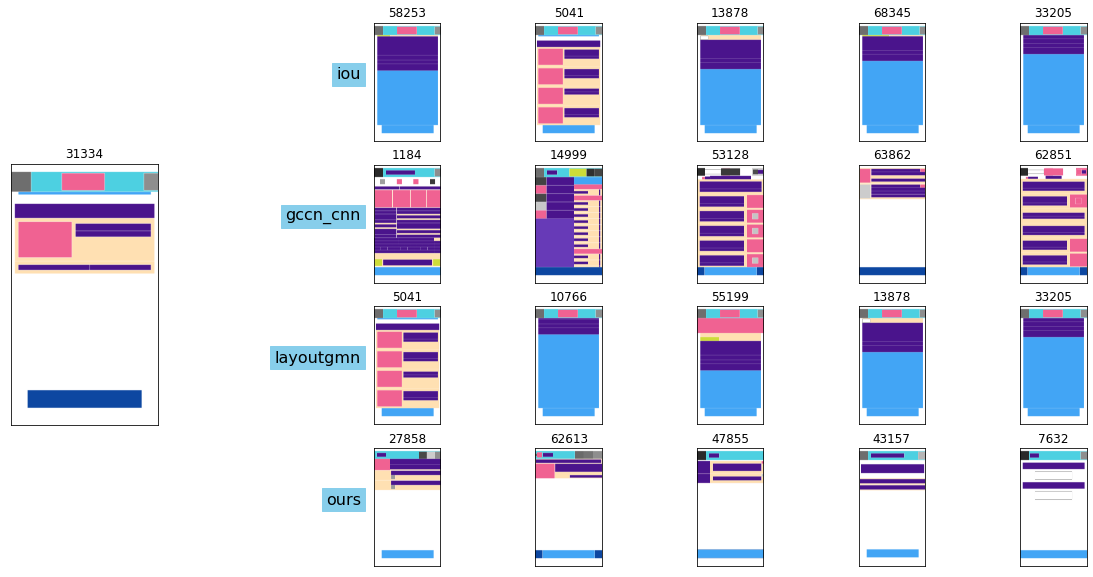

In [27]:
plot_query(query_results[5])


# Evaluate final model

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 64
NUM_WORKERS = multiprocessing.cpu_count()
# Encoder (GNN) arguments
LABEL_EMBEDDING_DIM = 64
BBOX_EMBEDDING_LAYER_DIMS = [32, 64]
GNN_HIDDEN_CHANNELS = 256
GNN_OUT_CHANNELS = None
GNN_NUM_LAYERS = 4
GNN_MODEL_CLS = GCN
USE_EDGE_ATTR = False
EDGE_LABEL_EMBEDDING_DIM = 16
READOUT = lambda x, inputs: global_mean_pool(x, batch=inputs.batch)
# Decoder (CNN) arguments
CNN_HIDDEN_DIM = 16
TRIPLET_LOSS_DISTANCE_FUNCTION = lambda x1, x2: 1 - F.cosine_similarity(x1, x2)
# Loss/optimizer parameters
TRIPLET_LOSS_MARGIN = .5
RECONSTRUCTION_LOSS_WEIGHT = 1
LR = 0.001

In [4]:
design_topics = pd.read_csv(DATA_PATH / 'design_topics.csv')
design_files = design_topics['screen_id'].tolist()
with open(DATA_PATH / 'train_split.json', 'r') as fp:
    splits = json.load(fp)
    
test_files = [f[:-4] for f in splits['test_uis']]

In [5]:
dataset = RICOSemanticAnnotationsDataset(
    datapoints=test_files
)
label_mappings = {k: i for i, k in enumerate(dataset.label_color_map)}

In [6]:
len(dataset)

13122

In [7]:
dataset.transform = transforms.Compose([
    transformations.process_data,
    transformations.normalize_bboxes,
    transformations.add_networkx,
    transformations.RescaleImage(IMAGE_SIZE, IMAGE_SIZE, allow_missing_image=True),
    transformations.ConvertLabelsToIndexes(
        node_label_mappings=label_mappings,
        edge_label_mappings={"parent_of": 0, "child_of": 1} if USE_EDGE_ATTR else None,
    ),
    transformations.convert_graph_to_pyg,
])

In [8]:
args = {'num_labels': len(label_mappings) + 1,
        'label_embedding_dim': LABEL_EMBEDDING_DIM,
        'bbox_embedding_layer_dims': BBOX_EMBEDDING_LAYER_DIMS,
        'gnn_hidden_channels': GNN_HIDDEN_CHANNELS,
        'gnn_num_layers': GNN_NUM_LAYERS,
        'gnn_out_channels': GNN_OUT_CHANNELS,
        'gnn_model_cls': GNN_MODEL_CLS,
        'use_edge_attr': USE_EDGE_ATTR,
        'num_edge_labels': 2,
        'edge_label_embedding_dim': EDGE_LABEL_EMBEDDING_DIM,
        'readout': READOUT,
        'cnn_output_dim': 3,
        'cnn_hidden_dim': CNN_HIDDEN_DIM,
        'cnn_output_size': IMAGE_SIZE,
        'triplet_loss_distance_function': TRIPLET_LOSS_DISTANCE_FUNCTION,
        'triplet_loss_margin': TRIPLET_LOSS_MARGIN,
        'reconstruction_loss_weight': RECONSTRUCTION_LOSS_WEIGHT,
        'lr':LR}

In [9]:
model = LayoutGraphModelCNNNeuralRasterizer.load_from_checkpoint(DATA_PATH / 'model' / 'epoch=4-step=16355.ckpt', **args)

In [10]:
data_loader = DataLoader(
    dataset=dataset, 
    batch_size=1, 
    collate_fn=pyg_data_with_image_collate, 
    num_workers=NUM_WORKERS,
    shuffle=True,
    persistent_workers=True
)

In [11]:
for batch in data_loader:
    encoding = model(batch['graph'])
    break

In [16]:
image = model.decoder(encoding.unsqueeze(-1).unsqueeze(-1))
image = image.transpose(1, -1).squeeze(0).detach().numpy()

true_image = batch['image'].squeeze(0).detach().numpy()

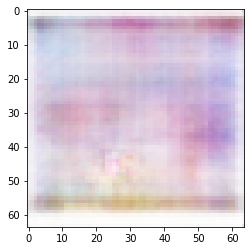

In [18]:
plt.imshow(image)

In [22]:
(true_image - image).mean()

0.06012125